In [72]:
import magic
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse
import scanpy.external as sce
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

## Utils and data loading

In [2]:
def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

def train_val_split(adata, seed=123, train_size=0.8, val_size=0.1, test_size=0.1):
    assert train_size + val_size + test_size == 1

    adata = adata.copy()
    np.random.seed(seed)

    cell_nums = adata.n_obs
    test_val = np.random.choice(cell_nums, int(cell_nums * (val_size + test_size)), replace=False)
    idx_train = [i for i in list(range(cell_nums)) if i not in test_val]
    idx_test = np.random.choice(test_val, int(len(test_val) * (test_size / (val_size + test_size))), replace=False)
    idx_val = [i for i in test_val if i not in idx_test]

    tmp = np.zeros(cell_nums, dtype=bool)
    tmp[idx_train] = True
    adata.obs['idx_train'] = tmp
    tmp = np.zeros(cell_nums, dtype=bool)
    tmp[idx_val] = True
    adata.obs['idx_val'] = tmp
    tmp = np.zeros(cell_nums, dtype=bool)
    tmp[idx_test] = True
    adata.obs['idx_test'] = tmp

    return adata

In [3]:
def pearsonr_error(y, h):
    res = []
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))

    for i in range(y.shape[0]):
        res.append(pearsonr(y[i], h[i])[0])
    return np.mean(res)


def cosine_similarity_score(y, h):
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))
    cos = cosine_similarity(y, h)
    res = []
    for i in range(len(cos)):
        res.append(cos[i][i])
    return np.mean(res)

In [128]:
adata = sc.read_h5ad('./data/Klein/masked/Klein_02.h5ad')
maskIndex = sparse.load_npz('./data/Klein/masked/Klein_maskIndex_02.csv.npz')

In [130]:
#adata = normalize(adata, filter_min_counts=False)
adata = train_val_split(adata,seed=321)

In [131]:
true_values=adata.raw.X.A
#size_factors =np.array(adata.obs.size_factors.values)
train_mask =adata.obs.idx_train
val_mask = adata.obs.idx_val
test_mask = adata.obs.idx_test

## MAGIC

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import copy
import anndata

In [132]:
magic_operator = magic.MAGIC()
magic_data = magic_operator.fit_transform(adata.X)

Calculating MAGIC...
  Running MAGIC on 2713 cells and 24021 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.25 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.57 seconds.
    Calculating affinities...
    Calculated affinities in 0.56 seconds.
  Calculated graph and diffusion operator in 7.39 seconds.
  Running MAGIC with `solver='exact'` on 24021-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 3.48 seconds.
Calculated MAGIC in 10.93 seconds.


In [9]:
#magic_data = size_factors.reshape(2713,1)*magic_data

In [79]:
magic_data

array([[2.59060723e-01, 5.24777224e-01, 2.71645748e-01, ...,
        4.11275583e-02, 1.50396650e+00, 1.47917607e-03],
       [2.64229328e-01, 5.55640578e-01, 3.31944694e-01, ...,
        3.77994369e-02, 1.47963672e+00, 3.17144519e-03],
       [2.76737002e-01, 5.03636281e-01, 3.25586882e-01, ...,
        3.51369063e-02, 1.44266915e+00, 2.10017067e-03],
       ...,
       [2.00788512e-01, 5.39156744e-01, 3.22674567e-01, ...,
        5.41645368e-02, 1.17280248e+00, 1.50893885e-02],
       [1.91847669e-01, 5.02387266e-01, 3.41404638e-01, ...,
        4.64924892e-02, 1.19547912e+00, 9.32798439e-03],
       [1.97619724e-01, 5.03769166e-01, 3.62095640e-01, ...,
        7.36190440e-02, 1.23677427e+00, 6.04872559e-03]])

In [137]:
cosine_similarity_score(magic_data,adata.raw.X.A)

0.9019046875869042

In [138]:
dropout_pred = magic_data[adata.obs.idx_test]
dropout_true = adata.raw.X.A[adata.obs.idx_test]

In [139]:
masking_row_test, masking_col_test = np.where(maskIndex.A[adata.obs.idx_test, :] > 0)

In [140]:
y = dropout_true[masking_row_test, masking_col_test]
h = dropout_pred[masking_row_test, masking_col_test]

In [141]:
mse = float('%.4f' % mean_squared_error(y, h))
mae = float('%.4f' % mean_absolute_error(y, h))
pcc = float('%.4f' % pearsonr_error(y, h))
cs = float('%.4f' % cosine_similarity_score(y, h))

In [142]:
print(mse,mae,pcc,cs)

9.9789 1.1433 0.8746 0.889


In [143]:
adata_pred = sc.AnnData(copy.deepcopy(magic_data))

C:\Users\23247\AppData\Local\Temp\ipykernel_12744\3333969701.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_pred = sc.AnnData(copy.deepcopy(magic_data))


In [144]:
magic_data

array([[2.58065196e-01, 5.31104651e-01, 2.70128723e-01, ...,
        4.02100235e-02, 1.51679367e+00, 1.36818176e-03],
       [2.63163518e-01, 5.58332607e-01, 3.31758879e-01, ...,
        3.92809555e-02, 1.48224098e+00, 3.38648555e-03],
       [2.77598833e-01, 5.21212437e-01, 3.19420793e-01, ...,
        3.19448011e-02, 1.40849789e+00, 1.97436749e-03],
       ...,
       [2.02839726e-01, 5.31480624e-01, 3.23480609e-01, ...,
        5.21157475e-02, 1.16642065e+00, 1.44907818e-02],
       [1.92371692e-01, 5.17030338e-01, 3.39843817e-01, ...,
        4.60259074e-02, 1.20263607e+00, 1.36349953e-02],
       [1.98432601e-01, 4.93214542e-01, 3.72458042e-01, ...,
        8.08293362e-02, 1.25856764e+00, 7.17192387e-03]])

In [145]:
nan_count = np.isnan(magic_data).sum()

print(f"矩阵中的 nan 数量为：{nan_count}")

矩阵中的 nan 数量为：0


In [146]:
nan_count = np.isnan(adata_pred.X).sum()

print(f"矩阵中的 nan 数量为：{nan_count}")

矩阵中的 nan 数量为：0


In [147]:
sc.pp.normalize_total(adata_pred)
sc.pp.log1p(adata_pred)
sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000)
adata_pred = adata_pred[:, adata_pred.var.highly_variable]
sc.pp.scale(adata_pred, max_value=10)

D:\Anaconda3\envs\imputes\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [148]:
clusters = adata.obs.cluster.values

In [149]:
kmeans = KMeans(n_clusters=len(set(clusters))).fit(adata_pred.X)
ari = float('%.4f' % adjusted_rand_score(clusters, kmeans.labels_))
nmi = float('%.4f' % normalized_mutual_info_score(clusters, kmeans.labels_))

D:\Anaconda3\envs\imputes\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [150]:
print(ari,nmi)

0.748 0.7382


In [151]:
ari

0.748

In [152]:
nmi

0.7382

In [153]:
X_imputed_all=copy.deepcopy(magic_data)

In [154]:
adata_imp_all=anndata.AnnData(X=X_imputed_all)

C:\Users\23247\AppData\Local\Temp\ipykernel_12744\3425330637.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp_all=anndata.AnnData(X=X_imputed_all)


In [155]:
adata_imp_all.obs['cluster']=adata.obs['cluster'].values

In [156]:
adata_imp_all.obs['cluster']=adata_imp_all.obs['cluster'].map({'d0': 0, 'd2': 1, 'd4': 2, 'd7': 3})

In [157]:
adata_imp_all.obs

,cluster
0,0
1,0
2,0
3,0
4,0
...,...
2708,3
2709,3
2710,3
2711,3


In [158]:
sc.pp.normalize_total(adata_imp_all)
sc.pp.log1p(adata_imp_all)
sc.pp.highly_variable_genes(adata_imp_all, n_top_genes=2000)
adata_imp_all = adata_imp_all[:, adata_imp_all.var.highly_variable]
sc.pp.scale(adata_imp_all, max_value=10)

D:\Anaconda3\envs\imputes\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [159]:
# 降维
sc.tl.pca(adata_imp_all, svd_solver='arpack')
sc.pp.neighbors(adata_imp_all, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_imp_all)

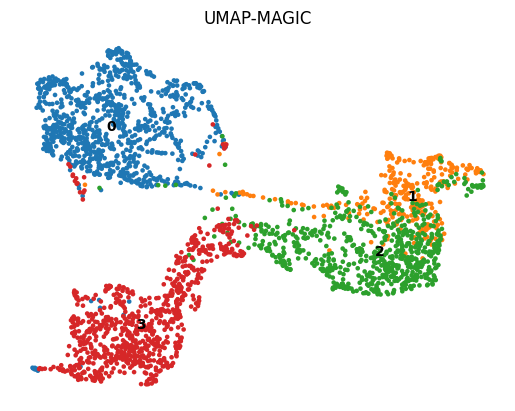

In [160]:
sc.pl.umap(adata_imp_all, color=['cluster'], legend_loc='on data', title='UMAP-MAGIC', frameon=False)

In [161]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# K-means聚类
kmeans = KMeans(n_clusters=4).fit(adata_imp_all.X)


ground_truth = adata_imp_all.obs.cluster.values
#cluster_results = adata_imp_all.obs['kmeans_clusters'].tolist()

ari = adjusted_rand_score(ground_truth, kmeans.labels_)
nmi = normalized_mutual_info_score(ground_truth, kmeans.labels_)

from sklearn.metrics import silhouette_score
# 计算轮廓系数
sil_score = silhouette_score(adata_imp_all.obsm['X_umap'],kmeans.labels_)



print("ARI: ", ari)
print("NMI: ", nmi)
print("Silhouette Score: ", sil_score)

D:\Anaconda3\envs\imputes\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI:  0.7475190404196916
NMI:  0.7377173739676129
Silhouette Score:  0.52708006


## DCA

In [36]:
from dca.api import dca

In [104]:
adata_dca_raw = anndata.AnnData(X=adata.X)

In [105]:
%%time
adata_dca = dca(adata_dca_raw, mode="denoise", copy=True, check_counts=False)

dca: Successfully preprocessed 24021 genes and 2713 cells.
dca: Calculating reconstructions...
CPU times: total: 27min 44s
Wall time: 2min 48s


In [106]:
adata_dca

AnnData object with n_obs × n_vars = 2713 × 24021
    obs: 'dca_split', 'n_counts', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

In [163]:
cosine_similarity_score(adata_dca.X,adata.raw.X.A)

0.88637245

In [108]:
dropout_pred = adata_dca.X[adata.obs.idx_test]
dropout_true = adata.raw.X.A[adata.obs.idx_test]

In [109]:
masking_row_test, masking_col_test = np.where(maskIndex.A[adata.obs.idx_test, :] > 0)

In [110]:
y = dropout_true[masking_row_test, masking_col_test]
h = dropout_pred[masking_row_test, masking_col_test]

In [111]:
mse = float('%.4f' % mean_squared_error(y, h))
mae = float('%.4f' % mean_absolute_error(y, h))
pcc = float('%.4f' % pearsonr_error(y, h))
cs = float('%.4f' % cosine_similarity_score(y, h))

In [112]:
print(mse,mae,pcc,cs)

9.967 1.1239 0.8471 0.8627


In [113]:
adata_pred = sc.AnnData(copy.deepcopy(adata_dca.X))

In [114]:
nan_count = np.isnan(adata_pred.X).sum()

print(f"矩阵中的 nan 数量为：{nan_count}")

矩阵中的 nan 数量为：0


In [115]:
sc.pp.normalize_total(adata_pred)
sc.pp.log1p(adata_pred)
sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000)
adata_pred = adata_pred[:, adata_pred.var.highly_variable]
sc.pp.scale(adata_pred, max_value=10)

D:\Anaconda3\envs\imputes\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [116]:
clusters = adata.obs.cluster.values

In [117]:
kmeans = KMeans(n_clusters=len(set(clusters))).fit(adata_pred.X)
ari = float('%.4f' % adjusted_rand_score(clusters, kmeans.labels_))
nmi = float('%.4f' % normalized_mutual_info_score(clusters, kmeans.labels_))

D:\Anaconda3\envs\imputes\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [118]:
print(ari,nmi)

0.8417 0.8512


In [119]:
X_imputed_all=copy.deepcopy(adata_dca.X)

In [120]:
adata_imp_all=anndata.AnnData(X=X_imputed_all)

In [121]:
adata_imp_all.obs['cluster']=adata.obs['cluster'].values

In [122]:
adata_imp_all.obs['cluster']=adata_imp_all.obs['cluster'].map({'d0': 0, 'd2': 1, 'd4': 2, 'd7': 3})

In [123]:
adata_imp_all.obs

,cluster
0,0
1,0
2,0
3,0
4,0
...,...
2708,3
2709,3
2710,3
2711,3


In [124]:
sc.pp.normalize_total(adata_imp_all)
sc.pp.log1p(adata_imp_all)
sc.pp.highly_variable_genes(adata_imp_all, n_top_genes=2000)
adata_imp_all = adata_imp_all[:, adata_imp_all.var.highly_variable]
sc.pp.scale(adata_imp_all, max_value=10)

D:\Anaconda3\envs\imputes\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [125]:
# 降维
sc.tl.pca(adata_imp_all, svd_solver='arpack')
sc.pp.neighbors(adata_imp_all, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_imp_all)

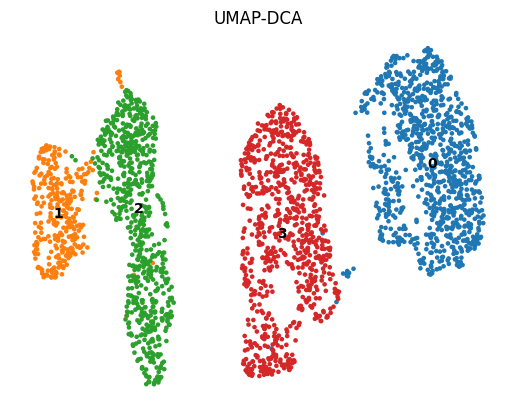

In [126]:
sc.pl.umap(adata_imp_all, color=['cluster'], legend_loc='on data', title='UMAP-DCA', frameon=False)

In [127]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# K-means聚类
kmeans = KMeans(n_clusters=4).fit(adata_imp_all.X)


ground_truth = adata_imp_all.obs.cluster.values
#cluster_results = adata_imp_all.obs['kmeans_clusters'].tolist()

ari = adjusted_rand_score(ground_truth, kmeans.labels_)
nmi = normalized_mutual_info_score(ground_truth, kmeans.labels_)

from sklearn.metrics import silhouette_score
# 计算轮廓系数
sil_score = silhouette_score(adata_imp_all.obsm['X_umap'],kmeans.labels_)



print("ARI: ", ari)
print("NMI: ", nmi)
print("Silhouette Score: ", sil_score)

D:\Anaconda3\envs\imputes\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI:  0.8417109937757791
NMI:  0.8511616364390134
Silhouette Score:  0.5544269
